In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates
from datetime import datetime, time ,date ,timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns
pd.options.mode.chained_assignment = None

In [2]:
import warnings
warnings.filterwarnings("ignore")

<h1> Functions </h1>

<h3> Fonctions générales </h3>

In [3]:
def floatise (df, list_columns_to_floatise):
    for i in list_columns_to_floatise:
        df[i] = df[i].apply(lambda x: float(x.replace(',','.')))
    return (df)

In [4]:
def intise (df, list_columns_to_floatise):
    for i in list_columns_to_floatise:
        df[i] = df[i].astype(int)
    return (df)

In [5]:
def flatten (table):
    if type(table.columns)==pd.MultiIndex:
        columns_to_look = [name_tmp for name_tmp in table.columns]

        columns_df = [ str(t[0])+'_'+str(t[1]) for t in columns_to_look]
        columns_df.insert(0,table.index.name)

        df = pd.DataFrame(columns = columns_df)

        index = 0
        for i in table.index:
            row = [table[r][i] for r in columns_to_look]
            row.insert(0,i)
            df.loc[index] = row
            index = index + 1
        return(df)
    else :
        table = pd.DataFrame(table)
        table.reset_index(level=0, inplace=True)
        return table

In [6]:
def flatten_soft(dataframe):
    res = pd.DataFrame()
    res[dataframe.index.name] = dataframe.index
    for col in dataframe.columns:
        name_tmp=""
        for i in range(len(dataframe.columns[0])):
            name_tmp = name_tmp +'_'+str(col[i])
        res[str(name_tmp)] = dataframe[col].values
    return res

<h3> Fonctions particulières </h3>

In [7]:
def cohort_attribution (x):
    if (x<2017):
        return 2016
    else :
        return x

In [8]:
def categorize_distribution_freq(x):
    if x==1:
        return('1 order')
    if x==2:
        return('2 orders')
    if (x>=3) & (x<=5):
        return('3-5 orders')
    if (x>=6) & (x<=10):
        return('6-10 orders')
    if x>10:
        return('10+ orders')

In [9]:
def categorize_distribution_order_price(x):
    if x<=25:
        return('0-25€')
    if (x>25) & (x<=50):
        return('26-50€')
    if (x>50) & (x<=100):
        return('51-100€')
    if (x>100) & (x<=200):
        return('101-200€')
    if (x>200) & (x<=500):
        return('201-500€')
    if x>500:
        return('>500€')

<h1> Dataset creation </h1>

<h3> Import de la data </h3>

In [10]:
src_root = os.getcwd()
print(src_root)

C:\Users\UgoMANTEL\Work\Github\Vertbaudet_2021\src\notebooks


- Préparation des colonnes:

In [11]:
col_names = ['AUFTRNR','KDNR','ARTNRERF','WTR','ARTGRERF','DATERF','PREISERF','PREIS','EKP','PREISNET','RABATT','RABATTSATZ',
             'MENGE','MENGERET','DEPARTEMENT','CAUFTRAGSPOS','MWST','MWSTRABATT','ANZKINDER','ANLAGEDAT',
             'DATAUFTRAG1','STRASSE','PLZ','ORT','BUNDESLAND','CLAND','CWERBESP','DATWERBESP','CLIEFERSP','DATLIEFERSP',
             'CADRESSSP','DATADRESSSP','UMSATZ1','DATLETZTAUFTR','UMSLETZTAUFTR','ANZKATLETZTAUFTR','WKOSTLETZTAUFTR',
             'DBKDNR','WKOSTENKUM','UMSATZKUM','UMSATZKUMTEL','UMSATZKUMFAX','UMSATZKUMWEB','UMSATZLIEFKUM','RUECKSTAUFTR',
             'ANZAUFTR','REFPRES','REFSTK','CODDOC','PLANEKP','RAYON','FAMILLE','DEPART','CODMARQ','ARTGROESSE','DATAUFTRAG',
             'DATERFASSUNG','DATVERARB','GUTSCHEINWERT']

In [12]:
dict_department = {'B':'BEBE','N':'PAP FILLE','U':'PAP GARCON','D':'CHAUSSURE','F':'FEMME',
'T':'TEXTILE HOME','P':'PUERICULTURE','W':'NON PAP ENFANT','K':'DECO','M':'CHAMBRE ET LITERIE','R':'JOUETS'}

<h3> Dataset </h3>

- Définition des répertoires :

In [13]:
repertoire = "C:/Users/UgoMANTEL/Work/Github/Vertbaudet_2021/data/1. Germany"

In [14]:
output_rep = "C:/Users/UgoMANTEL/eleven/Engagements - Vertbaudet/5. Analyses/3. Outputs python"

- Création de la donnée:

In [15]:
df = pd.DataFrame()
for file in os.listdir(repertoire):
    file_name_tmp = os.path.join(repertoire,file)
    df_tmp = pd.read_csv(file_name_tmp,sep=",",encoding= "unicode_escape", usecols=col_names)
    
    df_tmp = df_tmp.loc[df_tmp.CAUFTRAGSPOS!='$null$']
    df_tmp.CAUFTRAGSPOS = df_tmp.CAUFTRAGSPOS.astype(int)
    df_tmp = df_tmp.loc[df_tmp.CAUFTRAGSPOS <= 7]
    
    ################### CONVERSION DES CHAMPS ###################
    df_tmp['DATERF'] = pd.to_datetime(df_tmp.DATERF)
    df_tmp['DATAUFTRAG1'] = pd.to_datetime(df_tmp.DATAUFTRAG1)
    df_tmp.DEPARTEMENT = df_tmp.DEPARTEMENT.map(dict_department) 
    
    ################### CREATION DES CHAMPS ###################
    df_tmp['TOT_SALES'] = (df_tmp.PREIS - df_tmp.RABATT)*(df_tmp.MENGE - df_tmp.MENGERET)
    df_tmp['NET_DEMAND'] = (df_tmp.PREIS - df_tmp.RABATT) * df_tmp.MENGE
    df_tmp['GROSS_DEMAND'] = df_tmp.PREIS * df_tmp.MENGE
    df_tmp['YEAR_FIRST_ORDER'] = df_tmp.DATAUFTRAG1.dt.year
    df_tmp['YEAR_ORDER'] = df_tmp.DATERF.dt.year
    df_tmp['COHORT'] = df_tmp.YEAR_FIRST_ORDER.apply(lambda x: cohort_attribution(x))
    df_tmp['MONTH_RECRUITMENT'] = df_tmp.DATAUFTRAG1.dt.month
    df_tmp['ID_ORDER'] = df_tmp.AUFTRNR.astype(str) + '_'+ df_tmp.KDNR.astype(str)
    
    cat_order =  df_tmp.groupby(['ID_ORDER','DEPARTEMENT']).agg({'NET_DEMAND':sum}).reset_index().sort_values(by='NET_DEMAND',
    cat_order = cat_order.drop_duplicates(subset=['ID_ORDER'],keep='first')
    cat_order.columns = ['ID_ORDER','DEPARTEMENT_CMD','NET_DEMAND']
    df_tmp = pd.merge(df_tmp,cat_order[['ID_ORDER','DEPARTEMENT_CMD']], on='ID_ORDER', how='left', suffixes=(False,False))
    
    df_tmp = df_tmp[['DATERF','DATAUFTRAG1','DEPARTEMENT','TOT_SALES','NET_DEMAND','GROSS_DEMAND',
                    'YEAR_FIRST_ORDER','YEAR_ORDER','COHORT','MONTH_RECRUITMENT','ID_ORDER','KDNR','ARTNRERF',
                     'DEPARTEMENT_CMD','RABATT','RABATTSATZ','PREIS','ANZKINDER','MENGE','MENGERET']]
    df = pd.concat([df,df_tmp])
    del(df_tmp)

################### CREATION DE CHAMPS ###################
################### UNIVERS RECRUTEMENT
cat_rec = df.sort_values(by='DATERF',ascending=True).drop_duplicates(subset='KDNR', keep='first', inplace=False)[['KDNR','DEPARTEMENT_CMD']] 
cat_rec.columns = ['KDNR','DEPARTEMENT_FIRST']
df = pd.merge(df,cat_rec,on='KDNR',how='left',suffixes=(False,False))

################### DATE POUR LTV 12/24 MOIS
df['DATAUFTRAG1_12MONTH'] = df['DATAUFTRAG1']+ timedelta(days=365)
df['DATAUFTRAG1_24MONTH'] = df['DATAUFTRAG1']+ timedelta(days=730)

In [21]:
df.groupby(['YEAR_ORDER']).agg({'ID_ORDER' : pd.Series.nunique})

,ID_ORDER
YEAR_ORDER,
2017,847279
2018,779741
2019,683051
2020,772930
2021,807802


<h1> Etude macro de la base </h1>

In [24]:
plot = True 

In [39]:
net_demand = True

<h3>  Recrutements par mois:</h3> 

In [17]:
recrut = df.loc[(df.COHORT>=2017) & (df.COHORT<2021)].groupby(['COHORT','MONTH_RECRUITMENT']).agg({'KDNR' :pd.Series.nunique})
recrut = flatten_soft(recrut.unstack('MONTH_RECRUITMENT',fill_value=0))
recrut

,COHORT,_KDNR_1,_KDNR_2,_KDNR_3,_KDNR_4,_KDNR_5,_KDNR_6,_KDNR_7,_KDNR_8,_KDNR_9,_KDNR_10,_KDNR_11,_KDNR_12
0,2017,15064,14631,13453,12292,10832,8695,10887,11040,12280,11295,16639,9002
1,2018,15513,12001,14819,16927,17891,10853,11739,10032,12571,15249,16237,13492
2,2019,17018,12625,11923,12615,12249,10562,15915,13622,18146,17815,26030,16277
3,2020,17466,16055,14312,8906,9237,17608,26738,16957,20620,26068,33628,23763


In [18]:
recrut.to_csv(os.path.join(output_rep,'Recrut_per_month_GER.csv'),sep=";")

<h3>  Nombre d'enfants:</h3> 

In [25]:
np.max(flatten(df.groupby(['KDNR']).agg({'ANZKINDER' :'last'})).ANZKINDER)

2

In [41]:
flatten(df.groupby(['KDNR']).agg({'ANZKINDER' :'last'})).ANZKINDER.describe()

count    1.518597e+06
mean     1.317005e-06
std      1.622963e-03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+00
Name: ANZKINDER, dtype: float64

In [42]:
a=flatten(df.groupby(['KDNR']).agg({'ANZKINDER' :'last'}))

<h3> Prix moyen par univers:</h3> 

In [16]:
moy_price = flatten(df.groupby(['DEPARTEMENT']).agg({'PREIS' : 'mean','RABATT': 'mean'}))
moy_price['PRICE_NET'] = moy_price.PREIS - moy_price.RABATT
moy_price[['DEPARTEMENT','PRICE_NET']].to_csv(os.path.join(output_rep,'price-average_per_universe_GER.csv'),sep=";")

<h3> Nombre de commande par utilisateurs actifs par ans:</h3>

In [22]:
evol_nb_order = flatten(df.groupby(['YEAR_ORDER']).agg({'ID_ORDER' : pd.Series.nunique,'KDNR': pd.Series.nunique}))
evol_nb_order.columns = ['YEAR','NB_ORDER','NB_CUSTOMER']
evol_nb_order['FREQUENCY_ORDER'] = evol_nb_order.NB_ORDER/evol_nb_order.NB_CUSTOMER
evol_nb_order

,YEAR,NB_ORDER,NB_CUSTOMER,FREQUENCY_ORDER
0,2017,847279,469730,1.803757
1,2018,779741,454020,1.717416
2,2019,683051,428316,1.594736
3,2020,772930,495366,1.560321
4,2021,807802,529661,1.525130


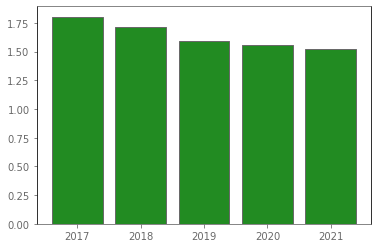

In [25]:
if plot:
    fig, ax = plt.subplots()
    ax.bar(evol_nb_order.YEAR,evol_nb_order.FREQUENCY_ORDER,color='forestgreen',edgecolor='dimgray')

    ##### Change axis and tick colors 
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['top'].set_color('dimgray')
    ax.xaxis.label.set_color('dimgray')
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')

<h3>Panier moyen par utilisateurs actifs par ans:</h3>

In [26]:
if net_demand:
    evol_average_order = flatten(df.groupby(['YEAR_ORDER']).agg({'ID_ORDER' : pd.Series.nunique,'NET_DEMAND': sum}))
else:
    evol_average_order = flatten(df.groupby(['YEAR_ORDER']).agg({'ID_ORDER' : pd.Series.nunique,'TOT_SALES': sum}))
evol_average_order.columns = ['YEAR','NB_ORDER','SALES']
evol_average_order['AVERAGE_ORDER'] = evol_average_order.SALES/evol_average_order.NB_ORDER
evol_average_order

,YEAR,NB_ORDER,SALES,AVERAGE_ORDER
0,2017,847279,8.476429e+07,100.042954
1,2018,779741,7.364496e+07,94.447983
2,2019,683051,6.053334e+07,88.621996
3,2020,772930,6.947944e+07,89.890980
4,2021,807802,7.408918e+07,91.717007


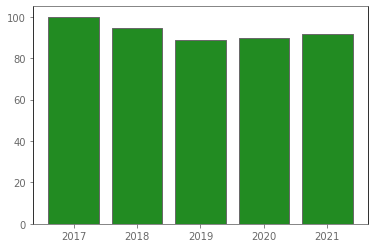

In [27]:
if plot:
    fig, ax = plt.subplots()
    ax.bar(evol_average_order.YEAR,evol_average_order.AVERAGE_ORDER,color='forestgreen',edgecolor='dimgray')

    ##### Change axis and tick colors 
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['top'].set_color('dimgray')
    ax.xaxis.label.set_color('dimgray')
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')

<h3>Nombre d'articles moyen par commandes:</h3>

In [30]:
evol_average_nb_article = flatten(df.groupby(['YEAR_ORDER']).agg({'ID_ORDER' : pd.Series.nunique,'MENGE': sum, 'MENGERET':sum}))
evol_average_nb_article.columns = ['YEAR','NB_ORDER','NB_ARTICLE_BOUGHT','NB_ARTICLE_RETURNED']
evol_average_nb_article['NB_ARTICLE'] = evol_average_nb_article.NB_ARTICLE_BOUGHT - evol_average_nb_article.NB_ARTICLE_RETURNED
if net_demand:
    evol_average_nb_article['AVERAGE_NB_ARTICLE'] = evol_average_nb_article.NB_ARTICLE_BOUGHT/evol_average_nb_article.NB_ORDER
else:
    evol_average_nb_article['AVERAGE_NB_ARTICLE'] = evol_average_nb_article.NB_ARTICLE/evol_average_nb_article.NB_ORDER
evol_average_nb_article

,YEAR,NB_ORDER,NB_ARTICLE_BOUGHT,NB_ARTICLE_RETURNED,NB_ARTICLE,AVERAGE_NB_ARTICLE
0,2017,847279,4264412,1548672,2715740,5.033067
1,2018,779741,3918347,1455943,2462404,5.025190
2,2019,683051,3071124,1097295,1973829,4.496185
3,2020,772930,3538263,1039993,2498270,4.577728
4,2021,807802,3881380,995278,2886102,4.804866


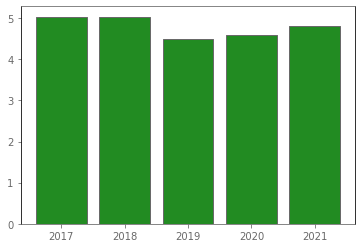

In [31]:
if plot:
    fig, ax = plt.subplots()
    ax.bar(evol_average_nb_article.YEAR,evol_average_nb_article.AVERAGE_NB_ARTICLE,color='forestgreen',edgecolor='dimgray')

    ##### Change axis and tick colors 
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['top'].set_color('dimgray')
    ax.xaxis.label.set_color('dimgray')
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')

<h3> Prix moyen des articles:</h3>

In [35]:
evol_average_price_article = flatten(df.groupby(['YEAR_ORDER']).agg({'NET_DEMAND' : sum,'MENGE': sum, 'MENGERET':sum}))
evol_average_price_article.columns = ['YEAR','NET_DEMAND','NB_ARTICLE_BOUGHT','NB_ARTICLE_RETURNED']
if net_demand:
    evol_average_price_article['AVERAGE_PRICE_ARTICLE'] = evol_average_price_article.NET_DEMAND/evol_average_price_article.NB_ARTICLE_BOUGHT
else:
    evol_average_price_article['NB_ARTICLE'] = evol_average_price_article.NB_ARTICLE_BOUGHT - evol_average_price_article.NB_ARTICLE_RETURNED
    evol_average_price_article['AVERAGE_PRICE_ARTICLE'] = evol_average_price_article.TOT_SALES/evol_average_price_article.NB_ARTICLE
evol_average_price_article

,YEAR,NET_DEMAND,NB_ARTICLE_BOUGHT,NB_ARTICLE_RETURNED,AVERAGE_PRICE_ARTICLE
0,2017,8.476429e+07,4264412,1548672,19.877135
1,2018,7.364496e+07,3918347,1455943,18.794906
2,2019,6.053334e+07,3071124,1097295,19.710485
3,2020,6.947944e+07,3538263,1039993,19.636594
4,2021,7.408918e+07,3881380,995278,19.088361


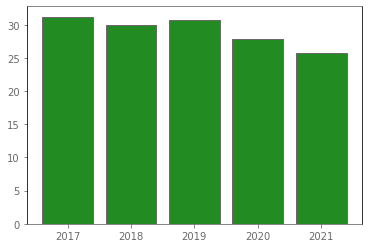

In [33]:
if plot:
    fig, ax = plt.subplots()
    ax.bar(evol_average_price_article.YEAR,evol_average_price_article.AVERAGE_PRICE_ARTICLE,color='forestgreen',edgecolor='dimgray')

    ##### Change axis and tick colors 
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['top'].set_color('dimgray')
    ax.xaxis.label.set_color('dimgray')
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')

<h3> Distribution des fréquences d'achat:</h3>

In [49]:
res_freq_distrib = pd.DataFrame({'CAT_FREQ':['1 order','2 orders','3-5 orders','6-10 orders','10+ orders']})
for year in range(2017,2022):
    distrib_freq = flatten(df[df.YEAR_ORDER==year].groupby(['KDNR']).agg({'ID_ORDER' : pd.Series.nunique}))
    distrib_freq.columns = ['KDNR','NB_ORDER']
    distrib_freq['CAT_FREQ'] = distrib_freq.NB_ORDER.apply(lambda x: categorize_distribution_freq(x))
    to_append = flatten(distrib_freq.groupby(['CAT_FREQ']).agg({'KDNR' : pd.Series.nunique}))
    to_append.columns = ['CAT_FREQ',str('VALUES_'+str(year))]
    res_freq_distrib = pd.merge(res_freq_distrib,to_append,on='CAT_FREQ',how='left',suffixes=(False,False))
res_freq_distrib

,CAT_FREQ,VALUES_2017,VALUES_2018,VALUES_2019,VALUES_2020,VALUES_2021
0,1 order,279269,286474,292905,344443,368622
1,2 orders,101649,92733,79236,89403,99681
2,3-5 orders,76457,64401,48372,53505,55117
3,6-10 orders,11327,9385,6899,7200,5791
4,10+ orders,1028,1027,904,815,450


In [50]:
res_freq_distrib.to_csv(os.path.join(output_rep,'distrib_freq_GERM.csv'),sep=";")

<h3> Distribution du prix des commandes:</h3>

In [37]:
res_order_distrib = pd.DataFrame({'CAT_ORDER':['0-25€','26-50€','51-100€','101-200€','201-500€','>500€']})
for year in range(2017,2022):
    distrib_order = flatten(df[df.YEAR_ORDER==year].groupby(['ID_ORDER']).agg({'NET_DEMAND' : sum}))
    distrib_order.columns = ['ID_ORDER','NET_DEMAND']
    distrib_order['CAT_ORDER'] = distrib_order.NET_DEMAND.apply(lambda x: categorize_distribution_order_price(x))
    to_append = flatten(distrib_order.groupby(['CAT_ORDER']).agg({'ID_ORDER' : pd.Series.nunique}))
    to_append.columns = ['CAT_ORDER',str('VALUES_'+str(year))]
    res_order_distrib = pd.merge(res_order_distrib,to_append,on='CAT_ORDER',how='left',suffixes=(False,False))
res_order_distrib

,CAT_ORDER,VALUES_2017,VALUES_2018,VALUES_2019,VALUES_2020,VALUES_2021
0,0-25€,93086,103366,101735,95840,104426
1,26-50€,176613,173298,168533,195618,199692
2,51-100€,280785,248497,213121,253091,258616
3,101-200€,203393,178633,141399,163274,172670
4,201-500€,89635,72932,55268,61640,68389
5,>500€,3767,3015,2995,3467,4009


In [38]:
res_order_distrib.to_csv(os.path.join(output_rep,'distrib_order_GERM_DN.csv'),sep=";")